# USG grants crawl
## Open Science Overview

### Previously

In the previous chapter, we loaded the [grants.gov](https://www.grants.gov/web/grants) grants database and looked at some summary characteristics of what it conatined.

In this chapter we'll move on to looking at the available data with the goal of learning more about how government grant solicitations might be targeting Open-Science

### Loading the database once more

Let's begin by loading up the database provided by the website, which is stored in an xml format.

In [1]:
from bs4 import BeautifulSoup
import xmltodict
import sys
import os
import pandas as pd
import glob

# import our helper functions
import sys
import os
sys.path.insert(0, os.path.abspath('../src'))
sys.path

#import the grantsGov_utilities modules
import analyzeData
import daskFuncs
import getData
import processData


# local data storage directory
localDataDir='../inputData'
# convert this to the absolute path
localDataDir=os.path.abspath(localDataDir)

# use the getData module to download the data from grants.gov
dataPath=getData.getDataFromRemoteSource(localDataDir,'grantsGov')
# print the contents of the dataPath.  If it's a file print it's size and type, if it's a directory print the first 100 file names
if os.path.isfile(dataPath):
    print(os.stat(dataPath))
else:
    print(os.listdir(dataPath)[0:100])

Searching for data in /media/dan/HD4/coding/gitDir/USG_grants_crawl/inputData/grantsGov...
The grants.gov data has already been downloaded.  No need to re-download.
The file is located at /media/dan/HD4/coding/gitDir/USG_grants_crawl/inputData/grantsGov/GrantsDBExtract20230601v2.xml.
os.stat_result(st_mode=33188, st_ino=1455749, st_dev=2096, st_nlink=1, st_uid=1000, st_gid=1000, st_size=278711375, st_atime=1685647519, st_mtime=1685646001, st_ctime=1685646001)


## Cleaning
As we noted in the previous chapter, we need to do a bit of cleaning, so lets do a more comprehensive version of that here.

Note:  This may take a moment

In [2]:
#processData.processDownloadedData(dataPath,'grantsGov',singleMulti='multi')
# the resultant data should be stored in the grantsGov/processed directory
processedDataPath=os.path.join(localDataDir,'grantsGov','processed')

### How do we find "Open Science Infrastructure"-related grants?

How can we tell which of these grants are related to-Open Science Infrastructure?  The `Description` field of the grant records contained in the database provide a potential target for filtering the grants.  If we can find a way to use the information contained within the description to determine whether or not the grant is related to this topic, we might be able to limit our consideration to this subset, and thereby be able to make insights about its characteristics.

Before we dive too deeply into using the `Description` it may be best for us to perform a sanity check and see how much information is contained within this field across the various grant entries. For this approach to be viable, a sufficient number of the grant descriptions will need to have a reasonable amount of text.

In [3]:
import h5py

# set the path to the list of terms to search for
currenthSearchList='OSterms_LeeChung2022'
searchTermsPath="../" + currenthSearchList + '.csv'
searchTermsPath=os.path.abspath(searchTermsPath)
# read in the search terms
searchTerms=pd.read_csv(searchTermsPath)
# in the case of any of the current keyword files:
# LeeChung2022, GPT_OS-Terms, keywords
# we have to use the *last* column of the csv file as our search terms (as a list of strings)
stringPhraseList=searchTerms.iloc[:,-1].tolist()
# we also need to lemmatize each of these
# it does this in the function
#for i in range(len(stringPhraseList)):
#    stringPhraseList[i]=analyzeData.prepareTextForNLP(stringPhraseList[i])
# for grantsGov we are using "Description" field, no need for list because the "Description" field is at the top of the xml structure.
fieldsSelect=['rootTag','Description']

# perform the search and save the results to a file
# this will take a while
# set savePath
savePath=os.path.join(localDataDir,'grantsGov','processed',currenthSearchList + '_results.h5')
analyzeData.regexSearchAndSave(processedDataPath,stringPhraseList,fieldsSelect,savePath=savePath)
# also take this opportunity to get the departments / agencies
agencyField=['rootTag','AgencyCode']
# get a list of the xml contents of the processedDataPath directory
inputStructs=os.listdir(processedDataPath)
# filter this down to the xml files
inputStructs=[x for x in inputStructs if x.endswith('.xml')]
# create full paths for all of these
inputStructs=[os.path.join(processedDataPath,x) for x in inputStructs]
# set the save path
savePath=os.path.join(localDataDir,'grantsGov','processed','grantsGov_agencies.h5')
analyzeData.fieldExtractAndSave(inputStructs,agencyField,nameField='infer',savePath=savePath)

TypeError: regexSearchAndSave() got an unexpected keyword argument 'caseSensitive'

ValueError: `bins` must be positive, when an integer

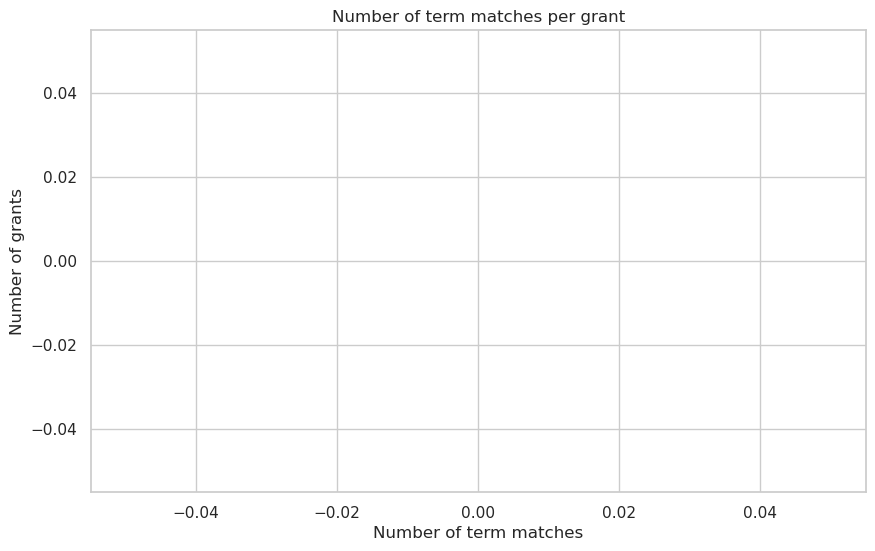

In [ ]:
# now we want to plot the results using seaborn
# start by loading the hdf5 file with the results
import h5py
# recall this is how we set the path previously
hd5Path=os.path.join(localDataDir,'grantsGov','processed',currenthSearchList + '_results.h5')
# load the file
saveDictionary=h5py.File(hd5Path,'r')

# we'll produce a bar plot where the x axis is the number of term matches in a given grant, and the y axis is the number of grants with that number of term matches
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
# set the seaborn style
sns.set(style="whitegrid")
# set the figure size
plt.figure(figsize=(10, 6))
# set the x axis label
plt.xlabel('Number of term matches')
# set the y axis label
plt.ylabel('Number of grants')
# set the title
plt.title('Number of term matches per grant')
# we'll need to convert the matrix into a histcount
# we'll start by iterating over the grants, which are the colums, and couting the number of non-zero entries
# initialize the list of counts as a vector of zeros
countsList=np.zeros(saveDictionary['dataMatrix'].shape[1])
# iterate over the columns
for i in range(saveDictionary['dataMatrix'].shape[1]):
    # count the number of non-zero entries
    countsList[i]=np.count_nonzero(saveDictionary['dataMatrix'][:,i])
print('The number of grants with no term matches is ' + str(np.count_nonzero(countsList==0)))
# then convert the countsList to a numpy array
# then plot the histogram
sns.histplot(countsList,binwidth=1,bins='auto')


In [ ]:
np.unique(countsList)

array([0.])

#### With a simple keyword search

We can make a first, naieve attempt at this by using a word-bank with words or phrases that we believe are likely to show up in a grant relevant to open science infrastructure (e.g. 'metadata', 'FAIR', 'data sharing', etc.).  In this repository we have just such a word-bank already available (in `keywords.txt`), but users should feel free to update and/or augment it as they see fit.

To begin then, we'll do a quick search to see how many grants each of the word-bank terms comes up in.

C:\Users\dbullock\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


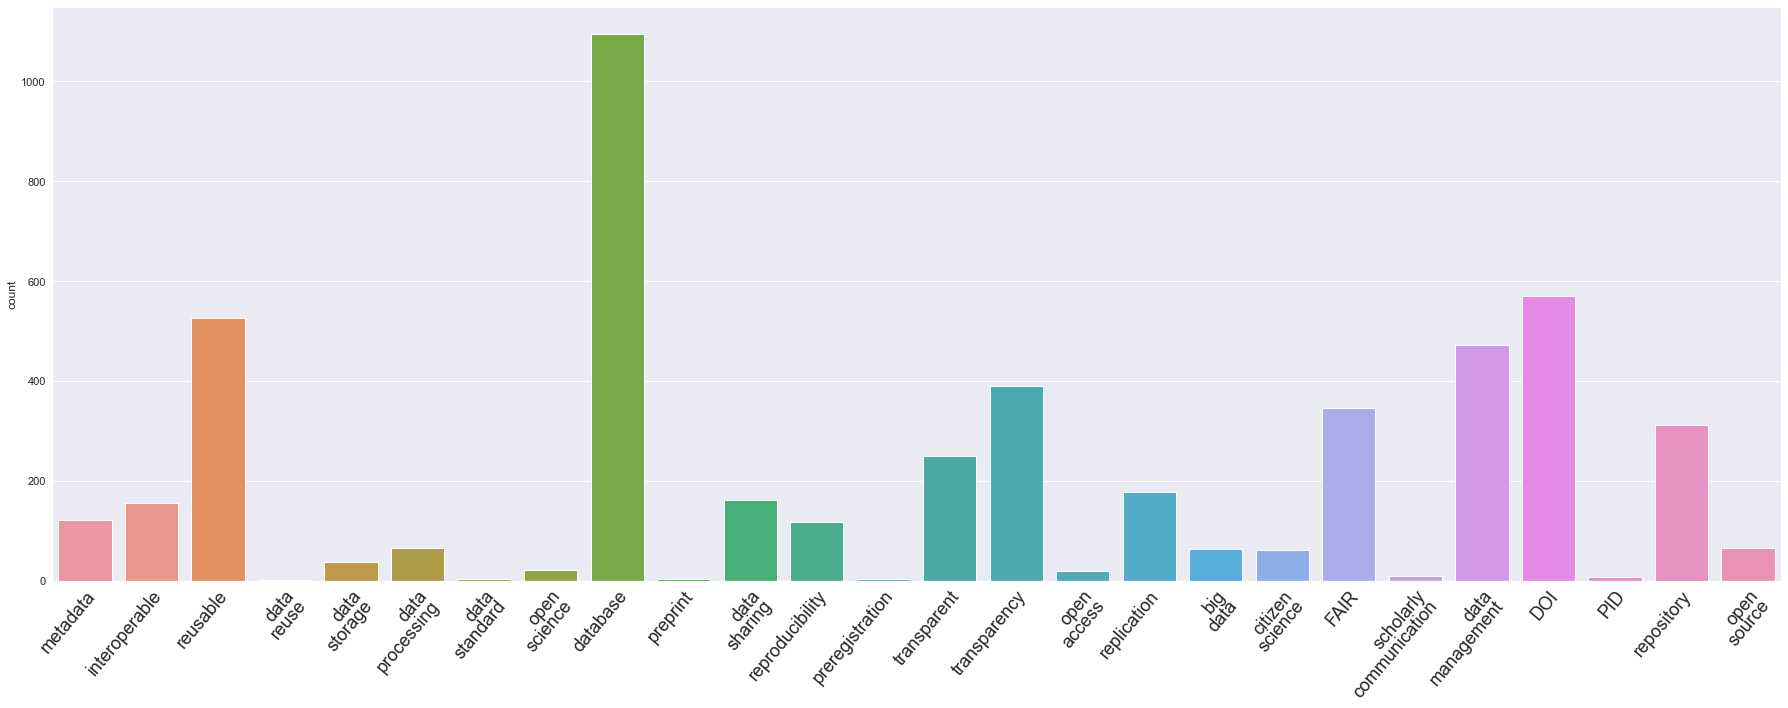

In [ ]:
import json
import seaborn as sns
import itertools
import pandas as pd
import matplotlib.pyplot as plt


# open the keywords file
with open('../keywords.txt', 'r') as f:
    keywords = f.read()

# split it into a list.  Each term is kept on a separate line
keywords=keywords.split('\n')

# create a dictionary which will be saved as a json, so that you don't have to do this each time
grantFindsOut={}

# iterate through the keywords
for iKeywords in keywords:
    # create a blank list to store the IDs of the grants with the keyword in the description
    grantsFound=[]
    compiledSearch=re.compile('\\b'+iKeywords.lower()+'\\b')
    for iRow,iListing in grantsDF.iterrows():
        # maybe it doesn't have a description field
        try:
            # case insensitive find for the keyword
            if bool(compiledSearch.search(iListing['Description'].lower().replace('-',''))):
                #append the ID if found
                grantsFound.append(iListing['OpportunityID'])
        except:
            # do nothing, if there's no description field, then the word can't be found
            pass
            
    # store the found entries in the output dictionary.  Use the keyword as the key (with spaces replaced with underscores),
    # and the value being the list of grant IDs
    grantFindsOut[iKeywords.replace(' ','_')]=grantsFound

# save it out
with open("grantFindsOut.json", "w") as outfile:
    json.dump(grantFindsOut, outfile)
    
# plot a histogram
#silly way to do this, but seaborn was giving me issues
import itertools
keywordCountVec=[]
for iKeywords in list(grantFindsOut.keys()):
    currVec=[iKeywords.replace('_','\n')] * len(grantFindsOut[iKeywords])
    keywordCountVec.extend(currVec)

import seaborn as sns
keywordHistDF=pd.DataFrame(data=keywordCountVec, columns=['keyword'])
#keywordHistDF.loc[0:10]=[len(grantFindsOut[iKeyword]) for iKeyword in grantFindsOut.keys()]
#keywordHistDF
sns.set(rc={'figure.figsize':(25,10)})
ax=sns.countplot(keywordCountVec)
ax.set_xticklabels(ax.get_xticklabels(), rotation=50, ha="right",rotation_mode='anchor',fontsize=18, linespacing=.8)
#ax.set_yticklabels(ax.get_yticklabels(),fontsize=20)
ax.tick_params(axis='both', which='major', pad=0)
plt.tight_layout()
plt.show()

#### The resulting plot

In the resulting plot we get a rough sense of how frequently these terms are coming up.  Admittedly, we don't actually know the context in which these terms are being used, so it's quite possible that they are being used with a different meaning in mind (e.g. "fair").  That being said, it's a only starting point, and maybe we can do better.

### Co-occurance

Perhaps it's not sufficient to know if _any_ of the relevant terms shows up in the gant description.  Maybe instead, we might want to require some number or subset of these terms to co-occur to help ensure that we're actually targeting relevant grants.  To consider this, we would want to look at which of these terms occur together and how frequently they do so.

Lets start with a basic matrix plot of these relations.

Text(0.5, 1.0, 'Open science term co-occurrences')

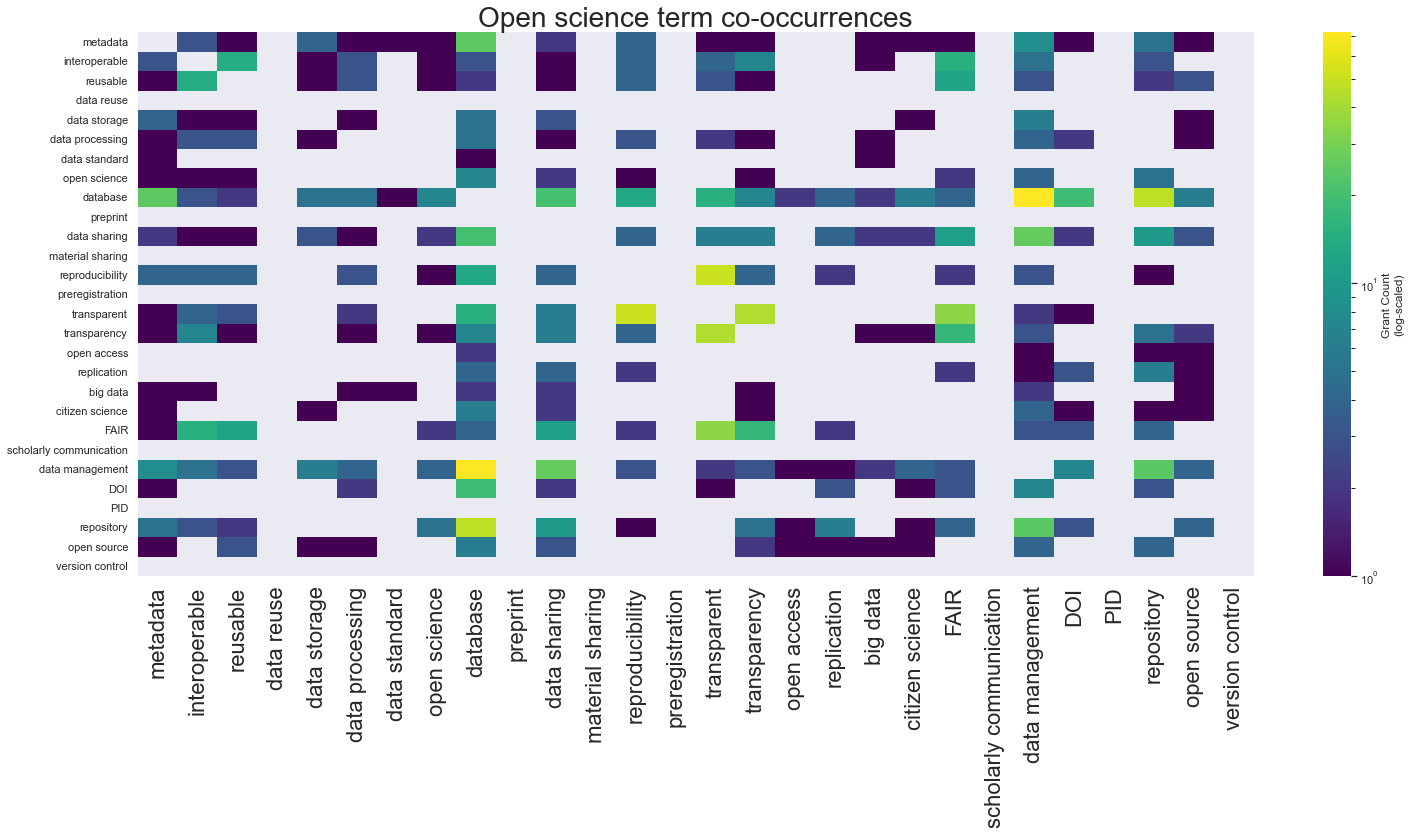

In [ ]:
import numpy as np
import copy
from matplotlib.colors import LogNorm
# ok, lets create a matrix that holds co-occurance data
# let's start by making a blank matrix to hold the data
connectivityMatrix=np.zeros((len(keywords),len(keywords)), dtype=np.int32())
# also make a list to hold the rows from this
dfRowContentAll=[]
# should be symmetric so x and y doesn't really matter
# use this opportunity to get the indexes of the lower triangle though
lowerTriIndices = [list(x) for x in np.tril_indices_from(connectivityMatrix)]
#convert this to the format we need
lowerTriList=[[lowerTriIndices[0][iIndex],lowerTriIndices[1][iIndex]] for iIndex in range(len(lowerTriIndices[0]))]
# iterate across both axes

for iIndexX, iKeywordsX in enumerate(keywords):
    for iIndexY, iKeywordsY in enumerate(keywords):
        # get the values for each "node" (e.g. the grant IDs for each keyword)
        IDsX=grantFindsOut[iKeywordsX.replace(' ','_')]
        IDsY=grantFindsOut[iKeywordsY.replace(' ','_')]
        # find the intersection
        intersectionGrants=list(set(IDsX) & set(IDsY))
        # find the size of that intersection
        sharedGrantNum=len(intersectionGrants)
        connectivityMatrix[iIndexX,iIndexY]=sharedGrantNum
        # do components for dataframe

        if not [iIndexX,iIndexY] in lowerTriList:
            print 
            
            if iKeywordsX==iKeywordsY:
                # half it for the visualization for self connections
                #dfRowContent=[iKeywordsX, iKeywordsY, np.divide(sharedGrantNum,2).astype(np.int32)]
                # or set it to zero
                dfRowContent=[iKeywordsX + ' (' + str(len(IDsX)) + ')', iKeywordsY + ' (' + str(len(IDsY)) + ')' , 0]
            else:
                dfRowContent=[iKeywordsX + ' (' + str(len(IDsX)) + ')', iKeywordsY + ' (' + str(len(IDsY)) + ')', sharedGrantNum]
            dfRowContentAll.append(dfRowContent)

flatConMatrix=pd.DataFrame(data=dfRowContentAll, columns=['keyword1','keyword2','value'])

# mask out the diagonal so it doesn't overwhelm the plot
diagonalMask=np.eye(len(keywords),dtype=bool)
# copy the matrix so it can be modified 
plotMatrix=copy.deepcopy(connectivityMatrix)
# set the diagonal to zero
plotMatrix[diagonalMask]=np.zeros(len(keywords))
# replace zero with empty, to clean up plot                

    
sns.heatmap(data=plotMatrix,yticklabels=keywords,xticklabels=keywords,cmap='viridis',norm=LogNorm(),cbar_kws={'label': 'Grant Count\n(log-scaled)'})
plt.gcf().get_axes()[0].set_xticklabels(plt.gcf().get_axes()[0].get_xticklabels(), fontsize=22)
plt.gcf().get_axes()[0].set_title('Open science term co-occurrences',fontsize=28)

#### A different view

The above matrix plot provides a good sense of the quantative characteristics of term co-occurance in the grants.  However, this sort of visualization may not completely encapsulate the overall patterns that we may be looking for.  For an alternate perspective we can try a chord diagram.

NOTE:  The code block below makes use of [d3blocks](https://github.com/d3blocks/d3blocks), which is a python package that is unlikely to be installed by default.  Also note, that this code block will open up a new window with the resulting figure.

In [ ]:
from d3blocks import D3Blocks
import os
# Initialize
d3 = D3Blocks()
# change the column names to what's required by d3blocks
# https://d3blocks.github.io/d3blocks/pages/html/Chord.html
flatConMatrix=flatConMatrix.rename(columns={"keyword1": "source", "keyword2": "target", 'value': 'weight'})
# notebook= True doesn't seem to work
# d3.chord(flatConMatrix,filepath=None,notebook=True)
d3.chord(flatConMatrix, showfig=False,filepath='./d3blocks.html')

import IPython
IPython.display.IFrame('d3blocks.html',height=900,width=1000)

[d3blocks] >INFO> Cleaning edge_properties and config parameters..
[d3blocks] >INFO> Cleaning edge_properties and config parameters..
[d3blocks] >INFO> Initializing [Chord]
[d3blocks] >INFO> filepath is set to [C:\Users\dbullock\Documents\code\gitDir\USG_grants_crawl\notebooks\d3blocks.html]
[d3blocks] >INFO> Convert to Frame.
[d3blocks] >INFO> Node properties are set.
[d3blocks] >INFO> Set edge-opacity based on the [source] node-opacity.
[d3blocks] >INFO> Set edge-colors based on the [source] node-color.
[d3blocks] >INFO> Edge properties are set.
